# Exploration des données

## Initialisation

 ### Installation des librairies

In [ ]:
# Mettre a jour l'environnement virtuel et les requirements.txt
%pip install -r ../requirements.txt 
%pip freeze > ../requirements.txt 

### Importation des librairies

In [ ]:
# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi # mettre clé API kaggle dans C:\Users\<VotreNom>\.kaggle\kaggle.json

# Global
import os
import shutil

# Data
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Images
import cv2

# Machine Learning
#import tensorflow as tf


## Téléchargement Data

In [ ]:
# Authentification
api = KaggleApi()
api.authenticate()

# URL du dataset à télécharger
dataset_url = 'tawsifurrahman/covid19-radiography-database'

# Chemin du dossier où le dataset sera extrait
destination_dir = os.path.abspath("../data")
dataset_folder = os.path.join(destination_dir, dataset_url.split('/')[-1])
print("Dossier de destination :", dataset_folder)

# Création du dossier de destination principal
os.makedirs(destination_dir, exist_ok=True)

# Vérification de l'existence du dossier du dataset
if os.path.exists(dataset_folder):
    print(f"Le dossier du dataset existe déjà : {dataset_folder}")
    print("Téléchargement ignoré.")
else:
    print("Téléchargement du dataset dans :", dataset_folder)
    api.dataset_download_files(
        dataset_url,
        path=dataset_folder,
        unzip=True
    )
    print("Dataset téléchargé avec succès dans :", dataset_folder)
    

## Analyse des Data

In [ ]:
path = os.path.join(dataset_folder,os.listdir(dataset_folder)[0])
os.listdir(path)

In [ ]:
normal_metadata = pd.read_excel(os.path.join(path, 'Normal.metadata.xlsx'), sheet_name='Sheet1')
normal_metadata.head()

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.manifold import Isomap
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
%matplotlib inline

Traitement des 3616 images dans le dossier : ..\data\covid19-radiography-database\COVID-19_Radiography_Dataset\COVID\images
Traitement de l'image 3616 sur 3616. Shape : (299, 299). Flat_Shape : (89401,) Name : COVID-999.png.  
Traitement terminé. Nombre d'images traitées : 3616
Création du DataFrame avec 89402 colonnes et 3616 lignes pour un total de 323277632 valeurs.
Shape du DataFrame : (3616, 89402)
Création du DataFrame terminée.
Sauvegarde du DataFrame dans un fichier CSV...


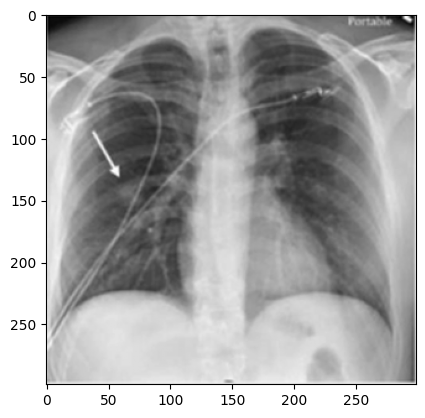

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

# Dossier contenant les images
image_folder = r'..\data\covid19-radiography-database\COVID-19_Radiography_Dataset\COVID\images'
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

data = []

total = len(image_files)   

# Définir les dimensions souhaitées pour redimensionner l'image
b_resize = True # Si False, les images ne seront pas redimensionnées
dsize = (299, 299) # Attention : (largeur, hauteur)
size_x, size_y = dsize

C1 = cv2.COLOR_BGR2RGB # conversion BGR → RGB pour affichage correct des couleurs
C2 = cv2.COLOR_BGR2GRAY # conversion BGR → GRAY pour traitement en niveaux de gris
C_selected = C2 # Choix de la conversion à appliquer



# Traitement des images
print(f"Traitement des {total} images dans le dossier : {image_folder}")
for i, file in enumerate(image_files, start=1):
    # Chargement de l'image
    img_path = os.path.join(image_folder, file)
    img = cv2.imread(img_path)
   
    # Redimensionner l'image à l'aide de cv2.resize
    if b_resize:
        img_resized = cv2.resize(img, dsize)
    else:
        img_resized = img

    # Conversion de l'image en niveaux de gris ou RGB
    img_selected = cv2.cvtColor(img_resized, C2) 
    print(f"Traitement de l'image {i} sur {total}. Shape : {img_selected.shape} Name : {file}", end='\r')
    
    
    # Conversion de l'image en tableau de pixels   
    pixels = np.array(img_selected).flatten()
    data.append([file] + list(pixels))

    print(f"Traitement de l'image {i} sur {total}. Shape : {img_selected.shape}. Flat_Shape : {pixels.shape} Name : {file}. ", end='\r')

print(f"\nTraitement terminé. Nombre d'images traitées : {len(data)}")


# Création du DataFrame

columns = ['filename'] + [f'pixel_{i}' for i in range(len(pixels))]
print(f"Création du DataFrame avec {len(columns)} colonnes et {len(data)} lignes pour un total de {len(data) * len(columns)} valeurs.")
df = pd.DataFrame(data, columns=columns)
print(f"Shape du DataFrame : {df.shape}")
print("Création du DataFrame terminée.")



# Sauvegarde du DataFrame dans un fichier CSV
print("Sauvegarde du DataFrame dans un fichier CSV...")
os.makedirs('../data/generated', exist_ok=True)  # Création du dossier si nécessaire
df.to_csv('../data/generated/images_pixels.csv', index=False , header=True , sep=',')


plt.imshow(img_selected, cmap='gray')
 


In [2]:
df = pd.read_csv('../data/generated/images_pixels.csv')

# Supprimer la colonne "filename"
data = df.drop(columns=['filename']).values


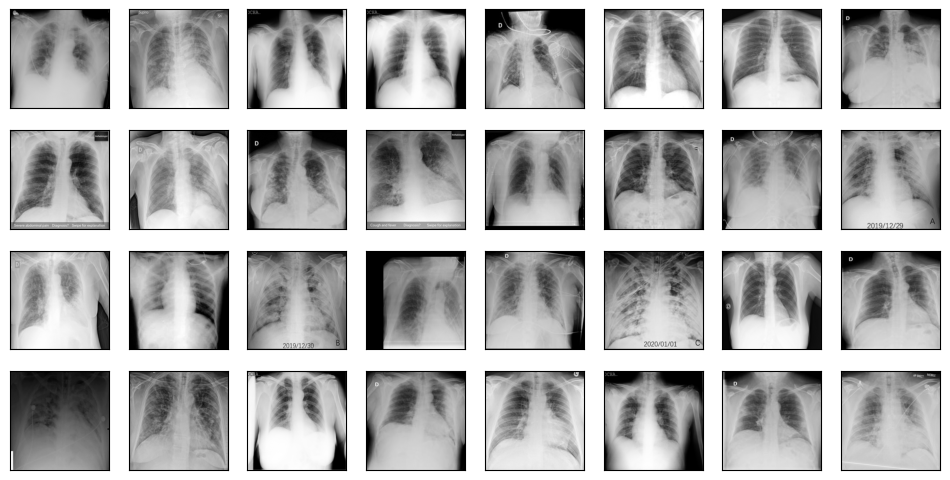

In [3]:
# Affichage des images
fig, ax = plt.subplots(4, 8, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):  # ax.flat transforme les axes en 1D
    if i >= len(data):
        break
    image_array = data[i].reshape(size_x, size_y)  # Redimensionner l'image à sa forme d'origine
    axi.imshow(image_array, cmap='gray')


In [4]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

ValueError: cannot reshape array of size 323274016 into shape (30,30)

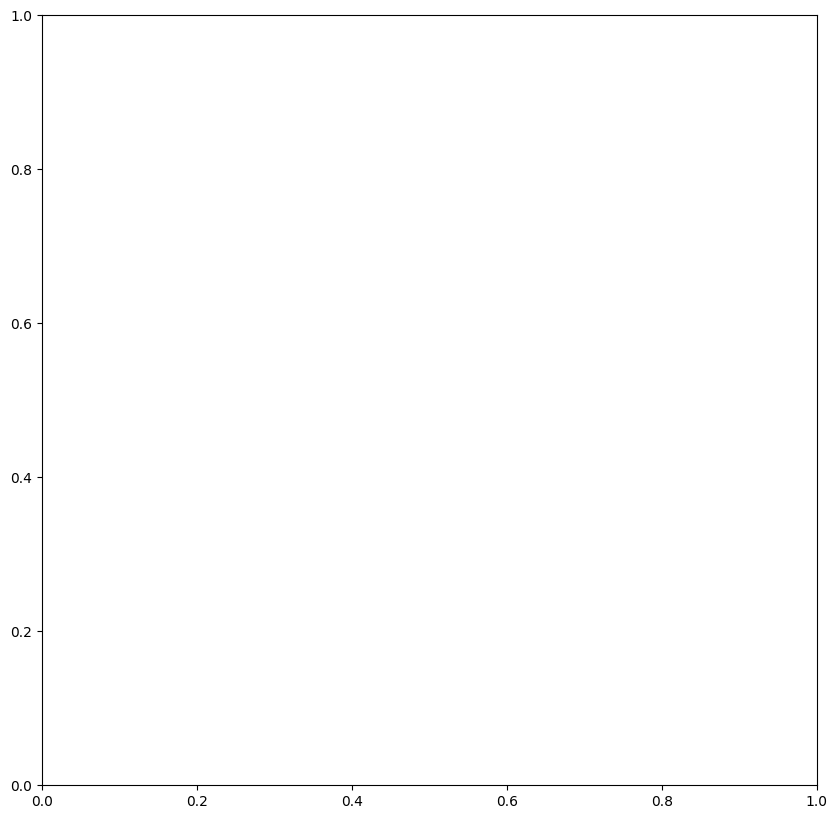

In [ ]:
from sklearn.manifold import Isomap
from matplotlib import offsetbox

fig, ax = plt.subplots(figsize=(10, 10))

plot_components(data,
                model=Isomap(n_components=2),
                images=data.reshape((-1,size_x, size_y)),
                cmap = 'gray',
                thumb_frac = .1)